<h1 style="text-align:center">
Classifying Process
</h1>

In [83]:
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold, RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, precision_score, f1_score, RocCurveDisplay, roc_auc_score, fbeta_score, balanced_accuracy_score, recall_score, ConfusionMatrixDisplay
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from typing import Tuple
from collections import defaultdict
from imblearn.over_sampling import SMOTE
import re

# Load and merge CSVs

In [97]:
# Function to merge CSV files
def merge_csvs(csv_list):
    # Load the first CSV
    merged_df = pd.read_csv(csv_list[0], index_col=0)
    
    # Merge the remaining CSVs
    for csv in csv_list[1:]:
        temp_df = pd.read_csv(csv)
        merged_df = merged_df.merge(temp_df, on=("ID", "Patient_ID"))
    
    return merged_df

# Train and compare models

### 1. Split dataset

A common pitfalls when evaluating and testing a classification model for potential lung nodule malignancy is not considering the nodules of the same patient to be completely separated into the training set or the validation set **[1]**.

In [98]:
def split_dataset(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    # Step 1: Get unique patient_ids
    unique_patients = df['Patient_ID'].unique()

    # Step 2: Split unique patient_ids
    train_patients, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=42)

    # Step 3: Filter original dataset based on the split patient_ids
    train_set = df[df['Patient_ID'].isin(train_patients)]
    test_set = df[df['Patient_ID'].isin(test_patients)]
    return train_set, test_set

In [99]:
def prepare_df(merged_df):
    merged_df = merged_df[merged_df["Malignancy"] != 3] # Remove Indeterminate malignancy
    merged_df.loc[merged_df["Malignancy"] < 3, "Malignancy"] = 0
    merged_df.loc[merged_df["Malignancy"] > 3, "Malignancy"] = 1

    train_set, test_set = split_dataset(merged_df)

    # Define features and target
    X_train = train_set.drop(columns=["ID", "Scan_ID", "Patient_ID", "Malignancy"])  # Exclude "ID", "Scan_ID", "Patient_ID" and "Malignancy" from features
    y_train = train_set["Malignancy"]  # Target variable
    groups_train = train_set["Patient_ID"]

    X_test = test_set.drop(columns=["ID", "Scan_ID", "Patient_ID", "Malignancy"])  # Exclude "ID", "Scan_ID", "Patient_ID" and "Malignancy" from features
    y_test = test_set["Malignancy"]  # Target variable

    return X_train, y_train, groups_train, X_test, y_test

### 2. Hyperparameter Tuning

We used the **RandomizedSearchCV** method, that allows for randomized sampling of hyperparameters to optimize the machine learning method.
The function accepts a classifier, a set of hyperparameter distributions to search over, the input data X and labels y, and a name for the model.

> **Preprocessing:** We created a **ColumnTransformer**, which applies **StandardScaler()** to scale the numeric features. This is crucial, especially for algorithms sensitive to feature scaling like XGBoost.

> **Pipeline Setup:** We created a pipeline that consists of the preprocessing step and the classifying step.

> **Cross-Validation:** We used **StratifiedKFold** cross-validation, which splits the data into 5 folds while ensuring that the distribution of classes remains balanced in each fold.

> **RandomizedSearchCV:** The next step is to perform hyperparameter tuning by randomly selecting hyperparameter combinations from the provided **param_distributions**.

> **Fitting the Model and Displaying Results:** After the tuning process and the fitting of each model, the function prints the best hyperparameters and the highest AUC score achieved during cross-validation.

In [111]:
# Function to perform RandomizedSearchCV
def tune_model(classifier, param_distributions, X, y, groups, model_name, pca_components=200, n_iter=10):
    #Synthetic Oversampling
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Define the preprocessor (if needed)
    # Here, we"ll standardize the numeric features
    numeric_features = [col for col in X.select_dtypes(include=["float64", "int64"]).columns if not col.startswith("cnn_")]
    cnn_features = [col for col in X.columns if col.startswith("cnn_")]
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),  # Standardize numeric features
            ("pca", PCA(n_components=pca_components), cnn_features), # Use pca for cnn features
        ]
    )

    # Create the pipeline
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),  # Preprocessing step
        ("classifier", classifier)  # Classifier passed as parameter
    ])

    # Setup StratifiedKFold cross-validation
    kf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

    # Metrics
    scoring = {
        "recall": make_scorer(recall_score),
        "precision": make_scorer(precision_score),
        "f1_score": make_scorer(f1_score),
        "f2_score": make_scorer(fbeta_score, beta=2),
        "balanced_accuracy": make_scorer(balanced_accuracy_score),
        "auc": make_scorer(roc_auc_score, response_method="predict_proba"),
    }

    # Setup RandomizedSearchCV
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions,
        n_iter=n_iter,  # Number of random combinations to try
        scoring=scoring,
        refit="recall",  # Use recall as the scoring metric
        cv=kf,
        random_state=42,
        n_jobs=-1,  # Use all available cores
        # return_train_score=True,
        # error_score='raise',
    )

    # Perform RandomizedSearchCV
    groups_resampled = pd.concat([groups, pd.Series([f"smoted-{i}" for i in range(len(X_resampled)- len(X))])])
    random_search.fit(X_resampled, y_resampled, groups=groups_resampled)

    # Display the best parameters and score
    print(f"{model_name} - Best parameters: {random_search.best_params_}")
    print(f"{model_name} - Best Recall score: {random_search.best_score_:.4f}")

    return random_search

In [112]:
def get_scores(cv_results: dict, best_index: int):
    """
    Extracts scores of the best estimator from the cv_results
    """
    scores = {}
    for key, values in cv_results.items():
        if re.match("^split._test_", key):
            metric_name = key.split('_')[2]  # Extract the metric name (e.g., "recall")
            
            # Initialize the metric entry in the results dictionary if not present
            if metric_name not in scores:
                scores[metric_name] = []
            
            scores[metric_name].append(values[best_index])

    return pd.DataFrame(scores)

In [7]:
def plot_metrics(models, X_test, y_test):
    _, ax = plt.subplots()
    for name, pipeline in models:
        RocCurveDisplay.from_estimator(pipeline, X_test, y_test, ax=ax, name=name)
    plt.title("ROC Curve")
    plt.show()

    metrics = defaultdict(list)
    names = []
    for name, pipeline in models:
        names.append(name)
        preds = pipeline.predict(X_test)

        metrics["precision"].append(precision_score(y_test, preds))
        metrics["f1_scores"].append(f1_score(y_test, preds))
        metrics["f2_scores"].append(fbeta_score(y_test, preds, beta=2))
        metrics["balanced_accuracy"].append(balanced_accuracy_score(y_test, preds))
        metrics["aucs"].append(roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]))

    plt.figure(figsize=(15, 10))
    for i, column in enumerate(metrics.keys()):
        plt.subplot(2, 3, i + 1)
        plt.bar(names, metrics[column])
        plt.ylabel("scale")
        plt.title(column)
        plt.ylim(bottom=0.65)
    plt.show()

    plt.figure(figsize=(12, 5))
    for i, (name, pipeline) in enumerate(models):
        ax = plt.subplot(2, 3, i + 1)
        plt.title(name)
        ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test, ax=ax)
    plt.plot()

###  XGBoost (xgb_param_distributions): 


- **n_estimators:** Number of boosting rounds or trees to grow, with values ranging from 50 to 300 in steps of 50.
- **max_depth:** Maximum depth of each tree, which controls the complexity of the model, sampled between 3 and 15.
- **learning_rate:** The step size at each iteration, ranging from 0.01 to 0.2 to control the contribution of each tree.
- **subsample:** Fraction of samples to be used in each boosting round, with values of 0.5, 0.7, and 1.0.
- **colsample_bytree:** Fraction of features used when building each tree, with values of 0.5, 0.7, and 1.0.
- **gamma:** Minimum loss reduction required to make a further partition in a leaf node, ranging from 0 to 5 in steps of 0.5.

In [113]:
# Parameter distributions for each classifier
xgb_param_distributions = {
    "classifier__n_estimators": np.arange(50, 300, 50),
    "classifier__max_depth": np.arange(3, 15),
    "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "classifier__subsample": [0.5, 0.7, 1.0],
    "classifier__colsample_bytree": [0.5, 0.7, 1.0],
    "classifier__gamma": np.arange(0, 5, 0.5),
}

### Random Forest (rf_param_distributions):

- **n_estimators:** Number of trees in the forest, sampled between 50 and 300 in steps of 50.
- **max_depth:** Maximum depth of each tree, sampled between 3 and 15.
- **min_samples_split:** Minimum number of samples required to split an internal node, with options of 2, 5, and 10.
- **min_samples_leaf:** Minimum number of samples required to be at a leaf node, with values of 1, 2, and 4.
- **max_features:** The number of features to consider when looking for the best split, with options "auto" and "sqrt".

In [114]:
rf_param_distributions = {
    "classifier__n_estimators": np.arange(50, 300, 50),
    "classifier__max_depth": np.arange(3, 15),
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__max_features": ["log2", "sqrt"],
}

' \n3 é irrelevante , remove\n1ª-> 1+2 bom, 4+5 mau                 corta-se max(1+2, 4+5)-min(1+2,4+5) a max(1+2,4+5)\n2ª-> 1*0.5+2*0.5 bom, 4*0.5+5*0.5 mau\n3ª-> w1, w2, w4, w5 \n4ª-> >=3 mau, else bom\n\n  ver diferênças entre as diff formas\n\n\nsendo 1, 5 os resultados mais seguros dar mais importância q o 2, 4\nr => nº de nodulos malig/benig\n'

In [115]:
merged_df = merge_csvs(["annotations_ds.csv"])
X_train, y_train, groups_train, X_test, y_test = prepare_df(merged_df)

In [116]:
# Tune models
ann_xgb_search = tune_model(XGBClassifier(eval_metric="mlogloss"), xgb_param_distributions, X_train, y_train, groups_train, "XGBoost")
ann_xgb = get_scores(ann_xgb_search.cv_results_, ann_xgb_search.best_index_)
ann_rf_search = tune_model(RandomForestClassifier(random_state=42), rf_param_distributions, X_train, y_train, groups_train, "Random Forest")
ann_rf = get_scores(ann_rf_search.cv_results_, ann_rf_search.best_index_)

      Texture  Spiculation  Lobulation  Margin  Sphericity  Calcification  \
0           5            2           2       3           4              6   
1           4            2           3       3           4              6   
2           5            1           1       5           5              5   
3           5            3           3       3           4              5   
4           5            5           5       4           4              6   
...       ...          ...         ...     ...         ...            ...   
1867        4            3           2       3           4              6   
1868        5            1           2       4           3              6   
1869        5            3           1       4           3              6   
1870        5            1           2       5           4              6   
1871        2            1           2       2           4              6   

      Internal Structure  Subtlety  
0                      1         4  
1

/tmp/ipykernel_8652/2538283197.py:40: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups_resampled = groups.append(pd.Series([f"smoted-{i}" for i in range(len(X_resampled)- len(X))]))


XGBoost - Best parameters: {'classifier__subsample': 0.7, 'classifier__n_estimators': 150, 'classifier__max_depth': 11, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.5, 'classifier__colsample_bytree': 1.0}
XGBoost - Best Recall score: 0.8593
      Texture  Spiculation  Lobulation  Margin  Sphericity  Calcification  \
0           5            2           2       3           4              6   
1           4            2           3       3           4              6   
2           5            1           1       5           5              5   
3           5            3           3       3           4              5   
4           5            5           5       4           4              6   
...       ...          ...         ...     ...         ...            ...   
1867        4            3           2       3           4              6   
1868        5            1           2       4           3              6   
1869        5            3           1       4        

/tmp/ipykernel_8652/2538283197.py:40: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups_resampled = groups.append(pd.Series([f"smoted-{i}" for i in range(len(X_resampled)- len(X))]))
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Random Forest - Best parameters: {'classifier__n_estimators': 250, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 13}
Random Forest - Best Recall score: 0.8686


/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152:

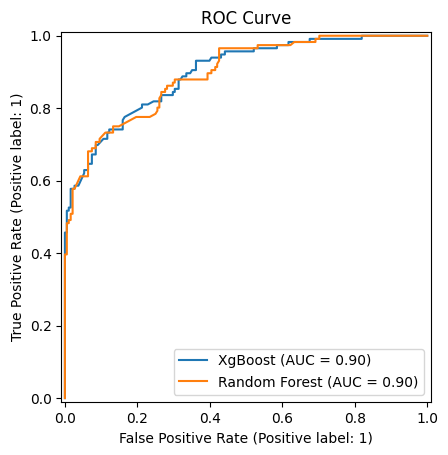

/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152:

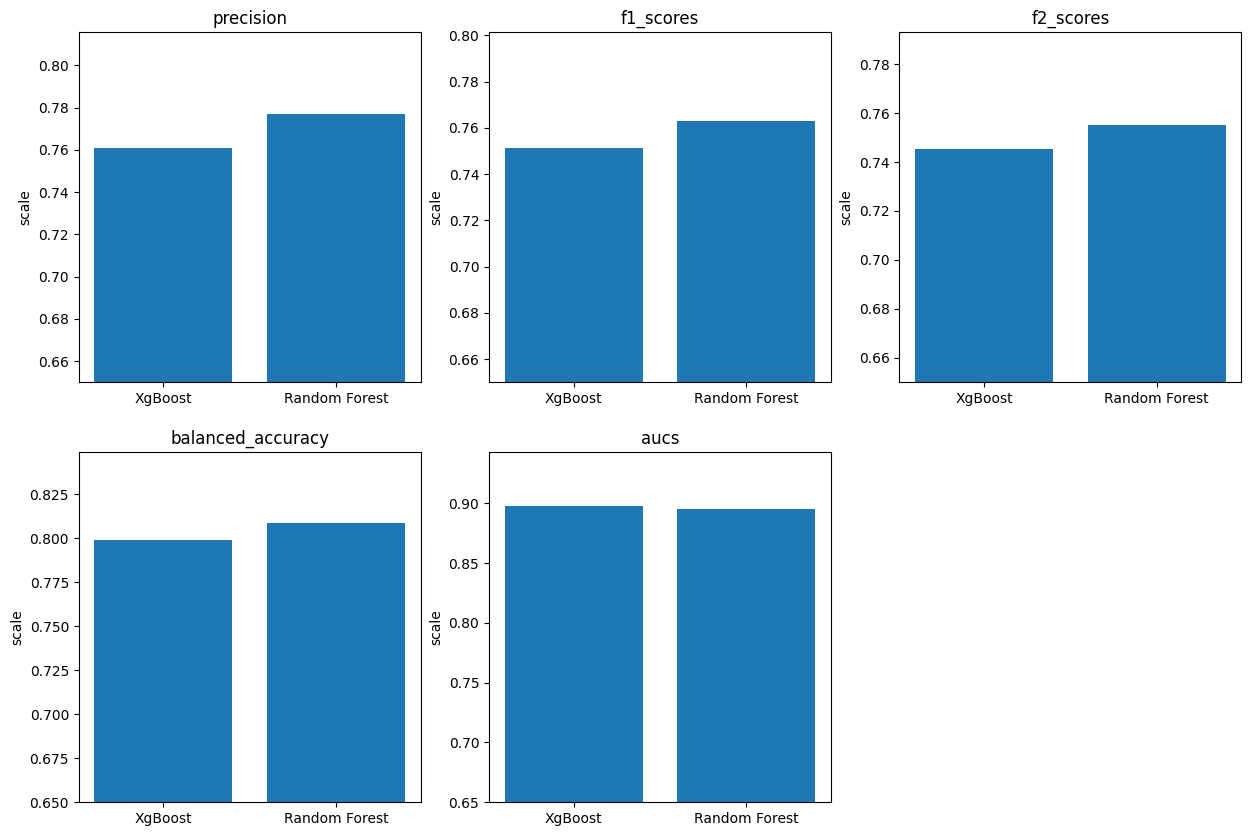

/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/inesamorim46/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152:

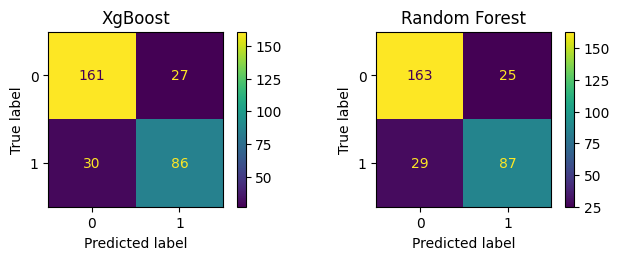

In [117]:
models = [
    ("XgBoost", ann_xgb_search.best_estimator_),
    ("Random Forest", ann_rf_search.best_estimator_),
]
plot_metrics(models, X_test, y_test)

# Annotations + Radiomics

In [118]:
merged_df = merge_csvs(["annotations_ds.csv", "radiomics.csv"])
X_train, y_train, groups_train, X_test, y_test = prepare_df(merged_df)

In [18]:
# Tune models
ann_rad_xgb_search = tune_model(XGBClassifier(eval_metric="mlogloss"), xgb_param_distributions, X_train, y_train, groups_train, "XGBoost")
ann_rad_xgb = get_scores(ann_rad_xgb_search.cv_results_, ann_rad_xgb_search.best_index_)

ann_rad_rf_search = tune_model(RandomForestClassifier(random_state=42), rf_param_distributions, X_train, y_train, groups_train, "Random Forest")
ann_rad_rf = get_scores(ann_rad_rf_search.cv_results_, ann_rad_rf_search.best_index_)

XGBoost - Best parameters: {'classifier__subsample': 0.7, 'classifier__n_estimators': 200, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.1, 'classifier__gamma': 2.0, 'classifier__colsample_bytree': 0.7}
XGBoost - Best Recall score: 0.8196


/home/psuper/Documents/Escola/Universidade/3º Ano/1_sem/lab_ia/trab1/lung-cancer-classification/.venv/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Random Forest - Best parameters: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'log2', 'classifier__max_depth': 12}
Random Forest - Best Recall score: 0.7928


In [ ]:
models = [
    ("XgBoost", ann_rad_xgb_search.best_estimator_),
    ("Random Forest", ann_rad_rf_search.best_estimator_),
]
plot_metrics(models, X_test, y_test)

# CNN features

In [ ]:
merged_df = merge_csvs(["annotations_ds.csv", "cnn_shallow.csv"])
X_train, y_train, groups_train, X_test, y_test = prepare_df(merged_df)

In [ ]:
# Tune models
best_xgb_model, best_xgb_params = tune_model(XGBClassifier(eval_metric="mlogloss"), xgb_param_distributions, X_train, y_train, groups_train, "XGBoost")
best_rf_model, best_rf_params = tune_model(RandomForestClassifier(random_state=42), rf_param_distributions, X_train, y_train, groups_train, "Random Forest")

XGBoost - Best parameters: {'classifier__subsample': 0.7, 'classifier__n_estimators': 200, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.1, 'classifier__gamma': 2.0, 'classifier__colsample_bytree': 0.7}
XGBoost - Best Recall score: 0.8196


/home/psuper/Documents/Escola/Universidade/3º Ano/1_sem/lab_ia/trab1/lung-cancer-classification/.venv/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Random Forest - Best parameters: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'log2', 'classifier__max_depth': 12}
Random Forest - Best Recall score: 0.7928


In [ ]:
models = [
    ("XgBoost", best_xgb_model),
    ("Random Forest", best_rf_model),
]
plot_metrics(models, X_test, y_test)

# Analysing the results

In [12]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import scikit_posthocs as sp

In [30]:
scores_df = pd.concat([
    ann_xgb.add_prefix("ann_xgb_"),
    ann_rf.add_prefix("ann_rf_"),
    ann_rad_xgb.add_prefix("ann-rad_xgb_"),
    ann_rad_rf.add_prefix("ann-rad_rf_"),
    # TODO: more
], axis=1)
scores_df.head()

,ann_xgb_recall,ann_xgb_precision,ann_xgb_f1,ann_xgb_f2,ann_xgb_balanced,ann_xgb_auc,ann_rf_recall,ann_rf_precision,ann_rf_f1,ann_rf_f2,...,ann-rad_xgb_f1,ann-rad_xgb_f2,ann-rad_xgb_balanced,ann-rad_xgb_auc,ann-rad_rf_recall,ann-rad_rf_precision,ann-rad_rf_f1,ann-rad_rf_f2,ann-rad_rf_balanced,ann-rad_rf_auc
0,0.845361,0.906077,0.874667,0.856844,0.877468,0.956515,0.876289,0.885417,0.880829,0.878099,...,0.901042,0.895445,0.900664,0.961614,0.881443,0.914439,0.897638,0.887850,0.898168,0.962464
1,0.876289,0.890052,0.883117,0.879007,0.878144,0.938792,0.891753,0.843902,0.867168,0.881753,...,0.936061,0.940391,0.931649,0.981414,0.953608,0.934343,0.943878,0.949692,0.939661,0.985979
2,0.798851,0.852761,0.824926,0.809080,0.834560,0.926887,0.821839,0.851190,0.836257,0.827546,...,0.893491,0.877907,0.898773,0.966263,0.890805,0.911765,0.901163,0.894919,0.904862,0.970767
3,0.830846,0.860825,0.845570,0.836673,0.852923,0.938168,0.855721,0.860000,0.857855,0.856574,...,0.918919,0.925743,0.921193,0.981919,0.915423,0.924623,0.920000,0.917248,0.922989,0.974572
4,0.861272,0.837079,0.849003,0.856322,0.846334,0.933929,0.890173,0.827957,0.857939,0.876993,...,0.914127,0.937500,0.910018,0.966326,0.936416,0.895028,0.915254,0.927835,0.912976,0.973148


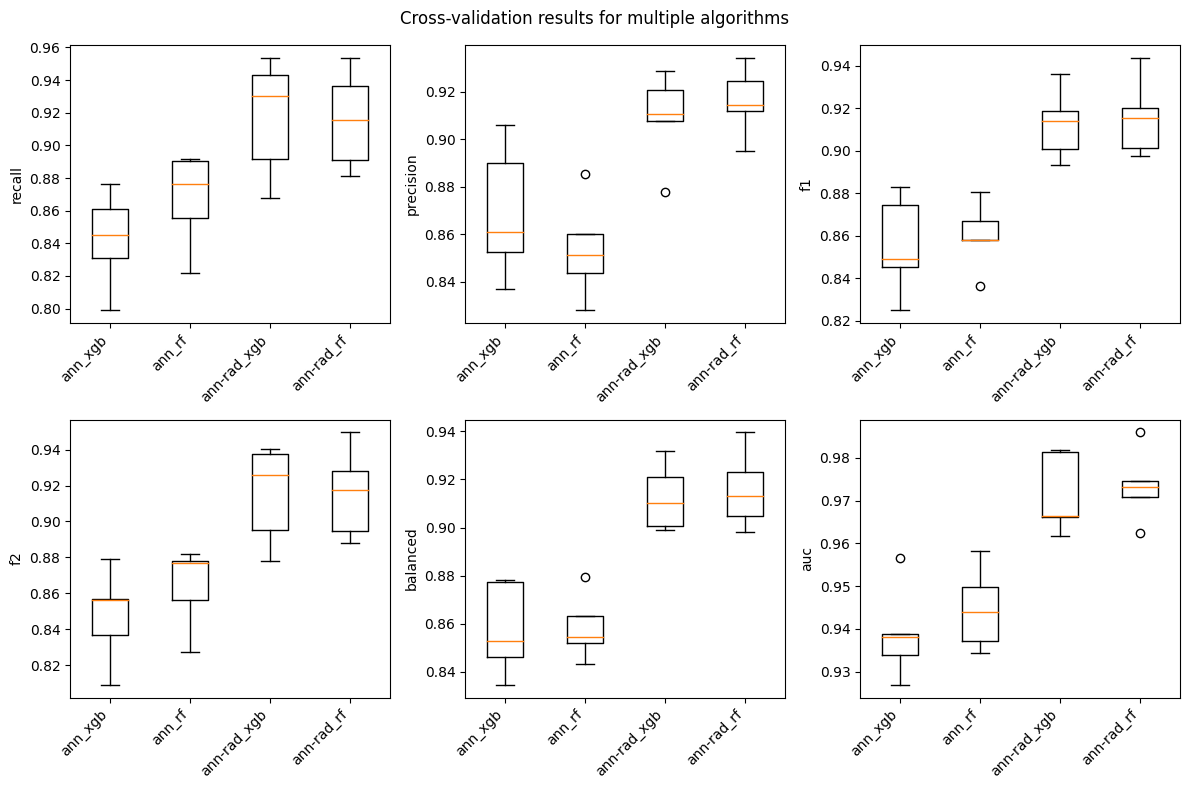

In [31]:
def plot_cv(results_cv, metrics, title="Cross-validation results for multiple algorithms"):
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    for i in range(len(metrics)):
        metric = metrics[i]

        ax[i//3, i%3].boxplot(results_cv.filter(regex=metric))
        ax[i//3, i%3].set_xticklabels(["_".join(c.split("_")[:2]) for c in results_cv.filter(regex=metric).columns], rotation=45, ha="right")
        ax[i//3, i%3].set_ylabel(metric.replace(".", "").replace("*", ""))

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_cv(scores_df, metrics=ann_xgb.columns.values)

In [32]:
def friedman(results_df: pd.DataFrame, alpha=0.05):
    statistic, pvalue = stats.friedmanchisquare(*[results_df[alg] for alg in results_df.columns])
    print(f"p value: {pvalue:4f}")

    if pvalue > alpha:
        print("Probably the same distribution")
    else:
        print("Probably different distributions")

    return sp.posthoc_nemenyi_friedman(results_df)


print("Balanced Accuracy:")
paired_comp_acc = friedman(scores_df.filter(like="balanced"))
print()
print("F1 Score:")
paired_comp_f1  = friedman(scores_df.filter(like="f1"))
print()
print("Roc AUC:")
paired_comp_auc = friedman(scores_df.filter(like="auc"))

Balanced Accuracy:
p value: 0.004467
Probably different distributions

F1 Score:
p value: 0.004467
Probably different distributions

Roc AUC:
p value: 0.002851
Probably different distributions


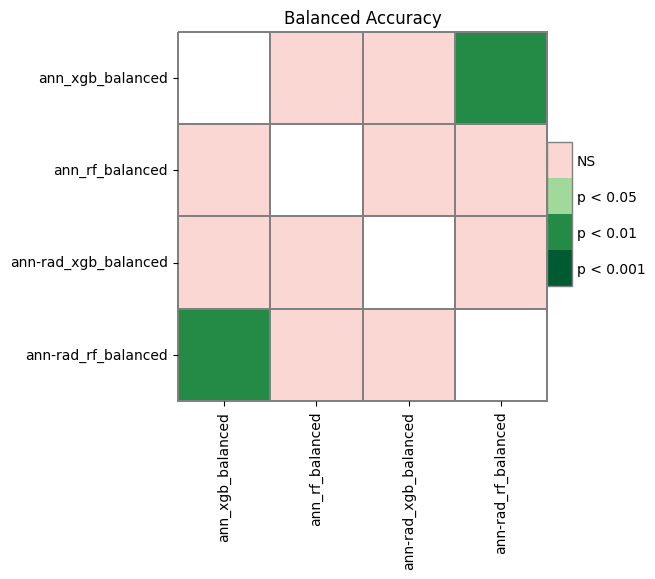

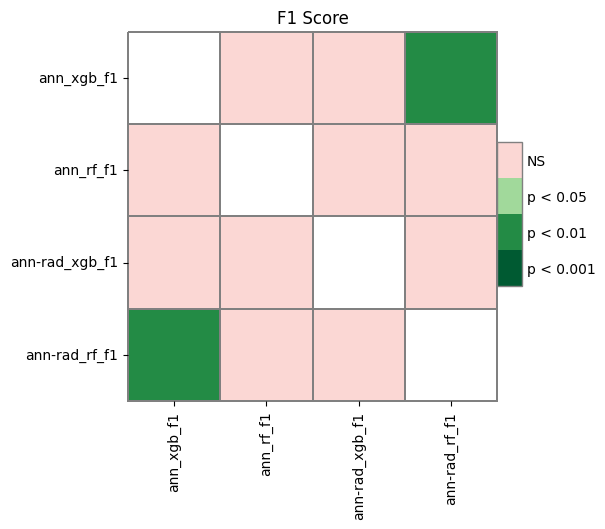

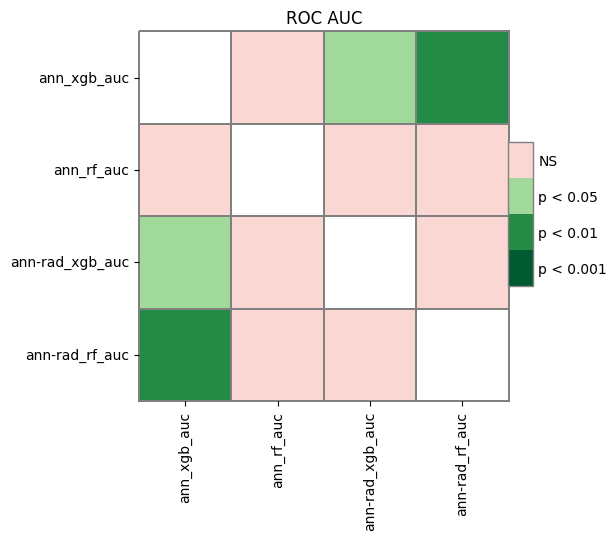

In [33]:
def plot_multiple_comp(paired_comp, title=""):
    plt.subplot()
    plt.title(title)

    # Generate a custom diverging colormap
    # cmap = sns.diverging_palette(230, 20, as_cmap=True)
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5',\
    'clip_on': False, 'square': True, \
    'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
    sp.sign_plot(paired_comp, **heatmap_args)

plot_multiple_comp(paired_comp_acc, "Balanced Accuracy")
plt.show()

plot_multiple_comp(paired_comp_f1, "F1 Score")
plt.show()

plot_multiple_comp(paired_comp_auc, "ROC AUC")
plt.show()

/home/psuper/Documents/Escola/Universidade/3º Ano/1_sem/lab_ia/trab1/lung-cancer-classification/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


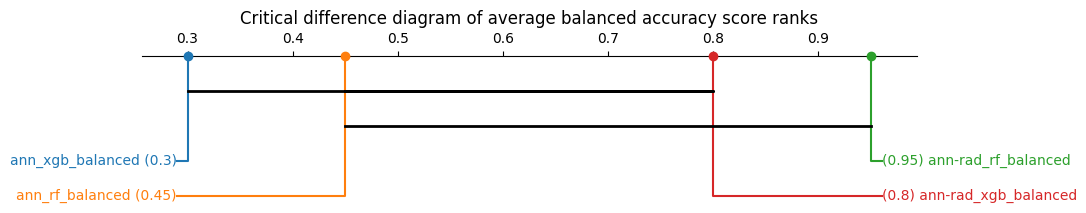

/home/psuper/Documents/Escola/Universidade/3º Ano/1_sem/lab_ia/trab1/lung-cancer-classification/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


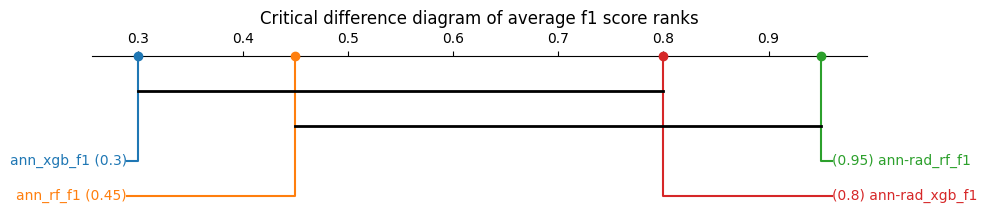

/home/psuper/Documents/Escola/Universidade/3º Ano/1_sem/lab_ia/trab1/lung-cancer-classification/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


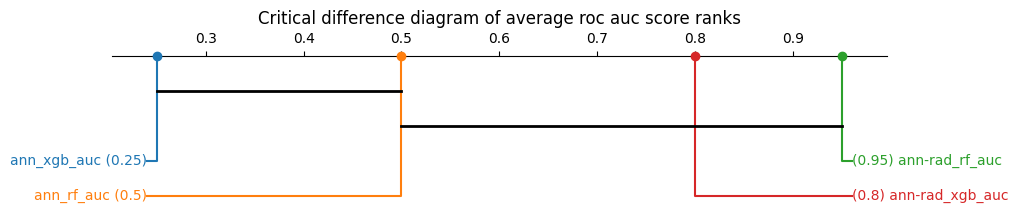

In [43]:
def critical_difference_diagram(df: pd.DataFrame, test_results, metric="metric"):
    data = (
        df.rename_axis('cv_fold')
          .melt(
              var_name='estimator',
              value_name='score',
              ignore_index=False,
          )
          .reset_index()
    )
    avg_rank = data.groupby('cv_fold').score.rank(pct=True).groupby(data.estimator).mean()

    plt.figure(figsize=(10, 2), dpi=100)
    plt.title(f'Critical difference diagram of average {metric} score ranks')
    sp.critical_difference_diagram(avg_rank, test_results)

critical_difference_diagram(scores_df.filter(like="balanced"), paired_comp_acc, "balanced accuracy")
plt.show()

critical_difference_diagram(scores_df.filter(like="f1"), paired_comp_f1, "f1")
plt.show()

critical_difference_diagram(scores_df.filter(like="auc"), paired_comp_auc, "roc auc")
plt.show()

## References

- [1] Causey, J.L., Zhang, J., Ma, S., Jiang, B., Qualls, J.A., Politte, D.G., Prior, F., Zhang, S. and Huang, X. (2018). Highly accurate model for prediction of lung nodule malignancy with CT scans. Scientific Reports, 8(1). doi:https://doi.org/10.1038/s41598-018-27569-w.